### Import Necessary Modules

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import time

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


ImportError: cannot import name 'clasification_report' from 'sklearn.metrics' (c:\Python312\Lib\site-packages\sklearn\metrics\__init__.py)

### Loading The Dataset

In [ ]:
columns = ["id", "topic", "label", "text"]

# Load taining and validation dataset
df_train = pd.read_csv('../data/twitter_training.csv', names = columns, encoding='ISO-8859-1')
df_val = pd.read_csv('../data/twitter_validation.csv', names = columns, encoding='ISO-8859-1')

# Concatenate data
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,topic,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.shape

(75682, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      75682 non-null  int64 
 1   topic   75682 non-null  object
 2   label   75682 non-null  object
 3   text    74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.label.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [ ]:
df.isna().sum()

id         0
topic      0
label      0
text     686
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

id       0
topic    0
label    0
text     0
dtype: int64

In [ ]:
# Show count of each label
label_value_counts = df['label'].value_counts()
label_value_counts

label
Negative      22624
Positive      20932
Neutral       18393
Irrelevant    13047
Name: count, dtype: int64

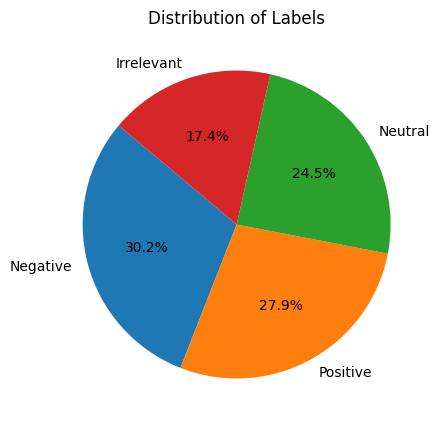

In [ ]:
#  Plot pie chart to show proportions of label
plt.figure(figsize=(5, 5))
plt.pie(label_value_counts, labels=label_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.show()

### Data Preprocessing

- lowercase
- remove URLs, mentions, hashtags, numbers, punctuations, and other non-word characters
- strip leading and trailing whitespace
- tokenize
- remove stop words and lemmatize

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stopwords = ['â', 'im']
stop_words.update(custom_stopwords)

# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs, mentions, hashtags, numbers, punctuations, and other non-word characters (special characters)
    text = re.sub(r'http\S+|www\S+|https\S+|@\S+|#\S+|\d+|[^\w\s]', '', text, flags=re.MULTILINE)

    # Strip leading and trailing whitespace
    text = text.strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back to string
    processed_text = ' '.join(tokens)
    
    # Check if the processed text is empty or contains only whitespace
    if processed_text.strip() == '':
        return None
    
    return processed_text

# Apply the preprocessing function to the text column
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
df['text'].head(13)

0                             getting borderland murder
1                                    coming border kill
2                               getting borderland kill
3                              coming borderland murder
4                             getting borderland murder
5                             getting borderland murder
6     spent hour making something fun dont know huge...
7     spent couple hour something fun dont know huge...
8     spent hour something fun dont know huge border...
9     spent hour making something fun dont know huge...
10    spent hour making something fun dont know huge...
11                                                 None
12    rockhard la varlope rare powerful handsome jac...
Name: text, dtype: object

Remove rows with empty text

In [ ]:
df.isna().sum()

id          0
topic       0
label       0
text     1705
dtype: int64

In [ ]:
df = df.dropna(subset=['text'])
df.reset_index(drop=True, inplace=True)
df.head(13)

,id,topic,label,text
0,2401,Borderlands,Positive,getting borderland murder
1,2401,Borderlands,Positive,coming border kill
2,2401,Borderlands,Positive,getting borderland kill
3,2401,Borderlands,Positive,coming borderland murder
4,2401,Borderlands,Positive,getting borderland murder
5,2401,Borderlands,Positive,getting borderland murder
6,2402,Borderlands,Positive,spent hour making something fun dont know huge...
7,2402,Borderlands,Positive,spent couple hour something fun dont know huge...
8,2402,Borderlands,Positive,spent hour something fun dont know huge border...
9,2402,Borderlands,Positive,spent hour making something fun dont know huge...


In [ ]:
df.isna().sum()

id       0
topic    0
label    0
text     0
dtype: int64

### Exploratory Data Analysis

Which words appear the most per positive, negative, and neutral tweets?

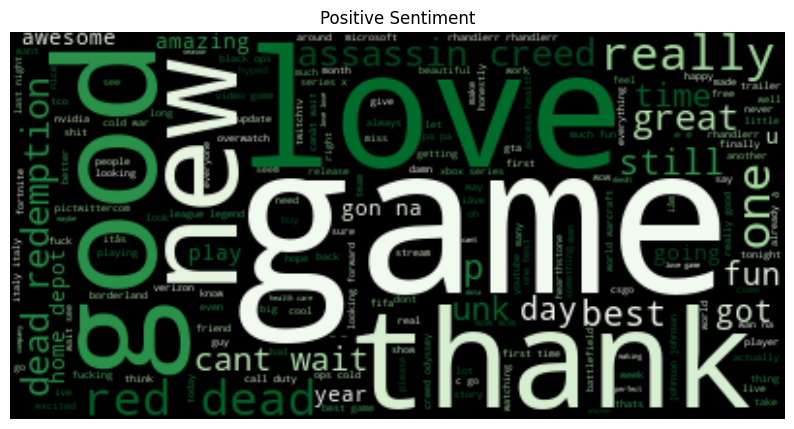

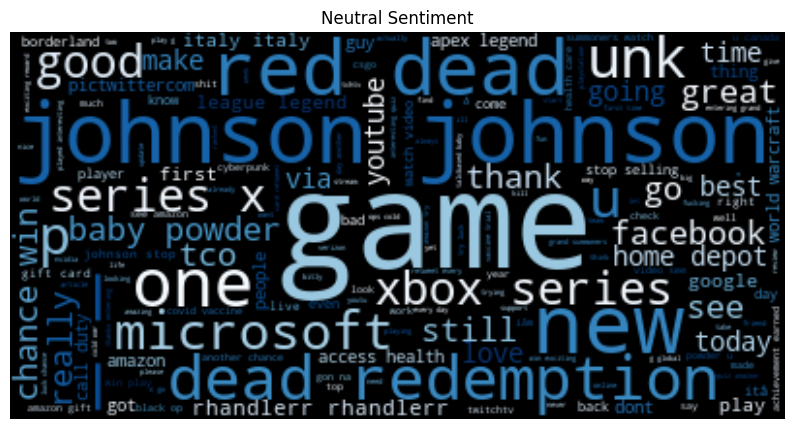

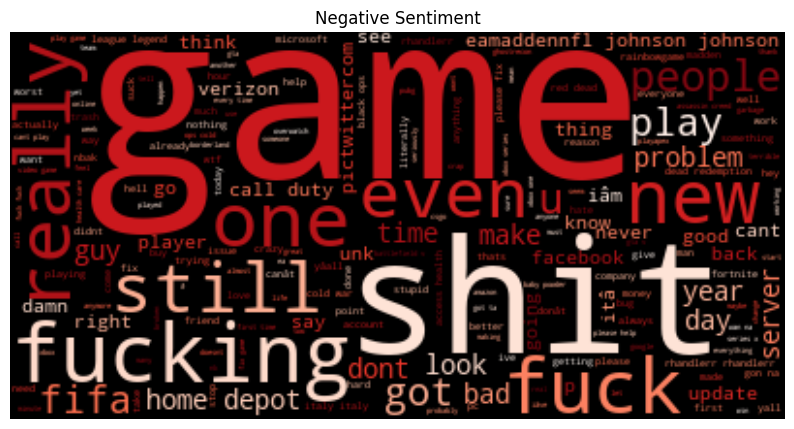

In [ ]:
# Function to generate and display word cloud
def generate_word_cloud(text, title, colormap):
    wordcloud = WordCloud(background_color='black', colormap=colormap).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Filter and concatenate text for positive, neutral, and negative labels
positive_text = ' '.join(df[df['label'] == 'Positive']['text'].dropna().astype(str).tolist())
neutral_text = ' '.join(df[df['label'] == 'Neutral']['text'].dropna().astype(str).tolist())
negative_text = ' '.join(df[df['label'] == 'Negative']['text'].dropna().astype(str).tolist())

# Generate and display word clouds with different color maps
generate_word_cloud(positive_text, 'Positive Sentiment', 'Greens')
generate_word_cloud(neutral_text, 'Neutral Sentiment', 'Blues')
generate_word_cloud(negative_text, 'Negative Sentiment', 'Reds')

Which topics have more Tweets?

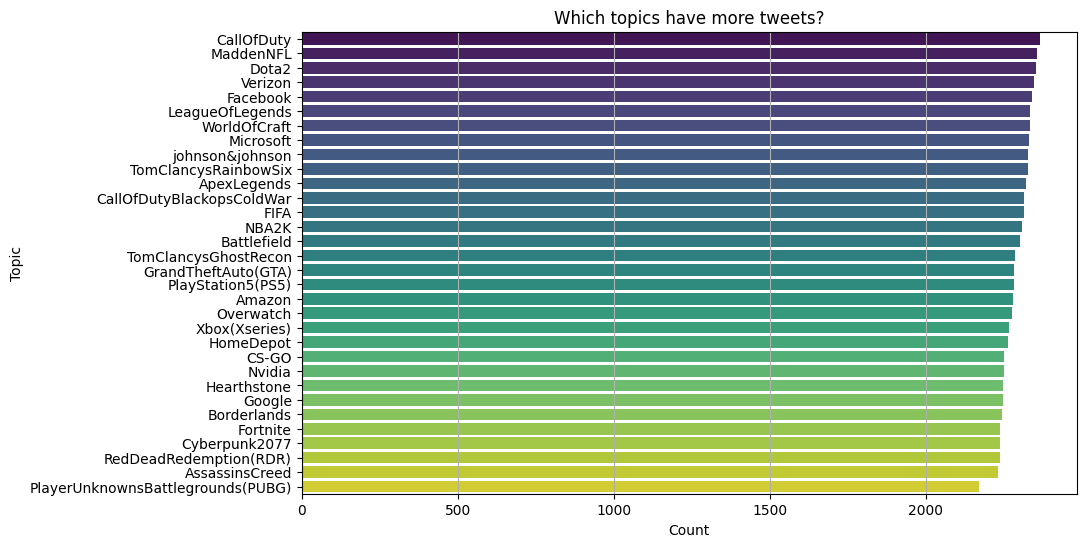

In [ ]:
topic_value_counts = df["topic"].value_counts().reset_index()
topic_value_counts.columns = ['topic', 'count']
topic_value_counts = topic_value_counts.sort_values(by='count', ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='count', y='topic', hue='topic', data=topic_value_counts, palette='viridis', dodge=False, legend=False)
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Which topics have more tweets?')
plt.grid(axis='x')

plt.show()

Which topics have the most positive, negative, and neutral tweets?

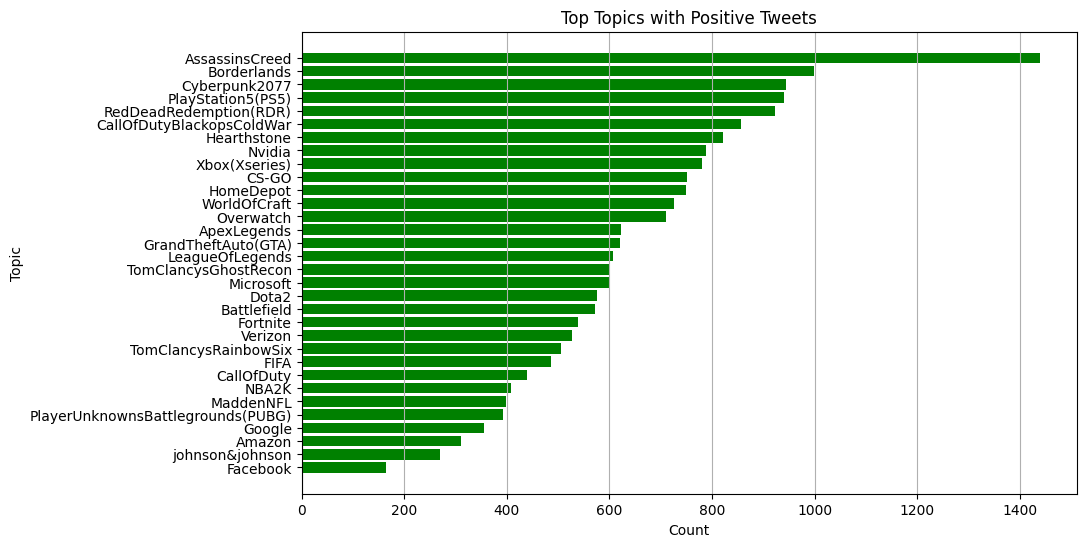

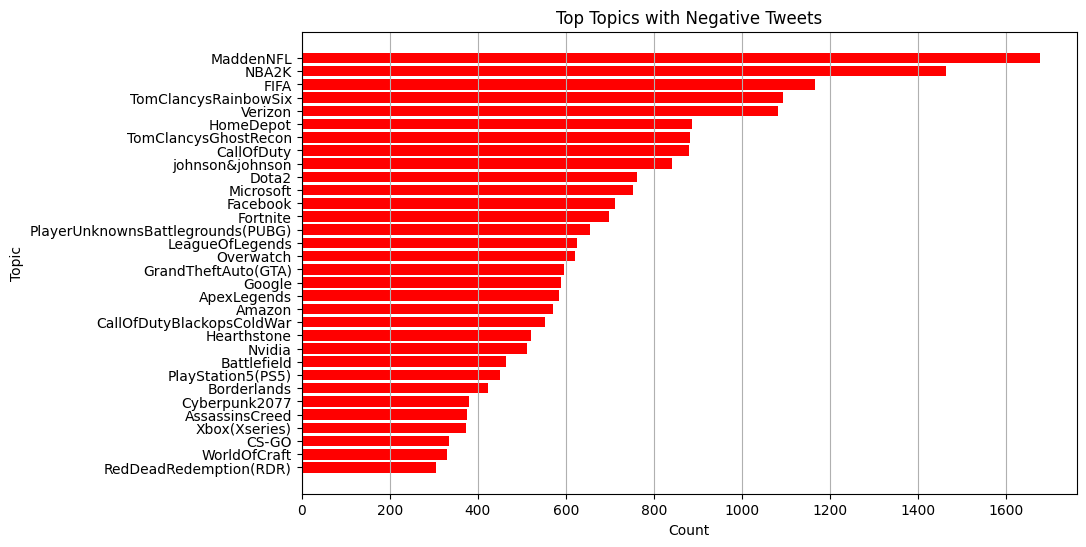

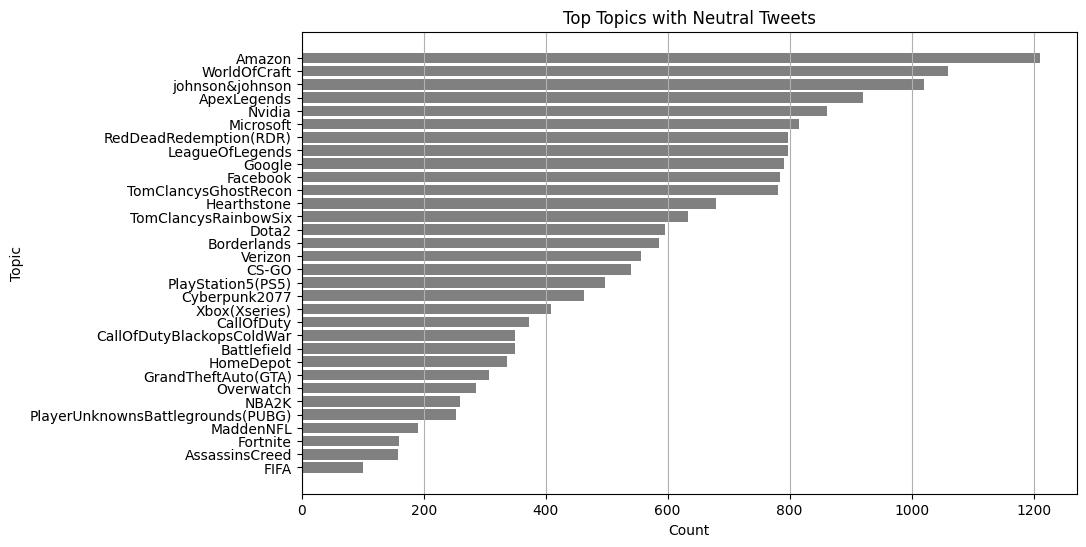

In [ ]:
def plot_sentiment_topics(df, sentiment_label):
    # Group by topic and label, and count the occurrences
    df_count = df.groupby(['topic', 'label']).size().reset_index(name='count')

    # Filter rows where label matches the specified sentiment_label
    df_filtered = df_count[df_count['label'] == sentiment_label]

    # Sort the df by count
    df_filtered = df_filtered.sort_values(by='count', ascending=True)

    # Define colors based on sentiment
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'grey'}

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(df_filtered['topic'], df_filtered['count'], color=colors[sentiment_label])
    plt.xlabel('Count')
    plt.ylabel('Topic')
    plt.title(f'Top Topics with {sentiment_label} Tweets')
    plt.grid(axis='x')
    plt.show()

# Call the function for each sentiment label
plot_sentiment_topics(df, 'Positive')
plot_sentiment_topics(df, 'Negative')
plot_sentiment_topics(df, 'Neutral')


### Label Encoding

In [ ]:
# Positive = 3
# Neutral = 2
# Negative = 1
# Irrelevant = 0

le_model = LabelEncoder()
df['label'] = le_model.fit_transform(df['label'])

### set X and y

In [ ]:
X= df['text']
y= df['label']

### Vectorize Text

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Apply vectorizer for X
X = vectorizer.fit_transform(X)

### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
print("X_train dimension:", X_train.shape)
print("X_test dimension:", X_test.shape)

X_train dimension: (58632, 36148)
X_test dimension: (14659, 36148)


### Building the Models

Function to measure training time and accuracy per model

In [ ]:
def train_and_eval(model, X_train, y_train, X_test, y_test):
    # Measure start time
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Measure end time
    end_time = time.time()
    
    # Calculate training time
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return training_time, accuracy

Define models

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Passive Aggressive': PassiveAggressiveClassifier(C=1.0, loss='hinge', tol=1e-3, max_iter=500, fit_intercept=True, random_state=42),
    'Logistic Regression': LogisticRegression(penalty=None,solver='sag',max_iter=500)
}

### Train and evaluate each model

In [ ]:
results = []

# Train and evaluate each model
for model_name, model in models.items():
    training_time, accuracy = train_and_eval(model, X_train, y_train, X_test, y_test)
    results.append({
        'Model': model_name,
        'Training Time (seconds)': training_time,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

print(results_df)

KeyboardInterrupt: 

### Model Evaluation

Compare Training Time of each model

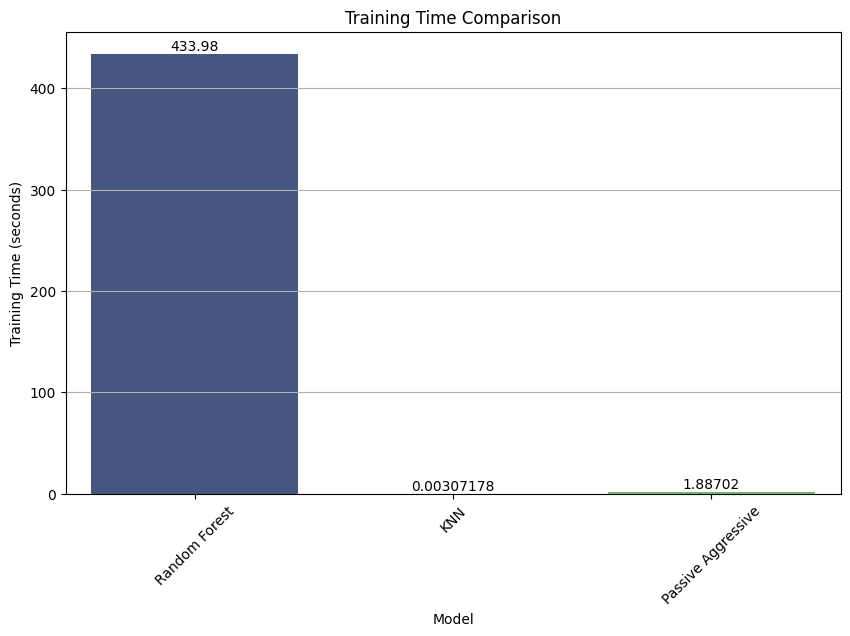

In [ ]:
# Plot training time
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Model', y='Training Time (seconds)', hue='Model', data=results_df, palette='viridis', dodge=False, legend=False)
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values per bar
for container in ax1.containers:
    ax1.bar_label(container)

plt.show()

Compare Accuracy of each model

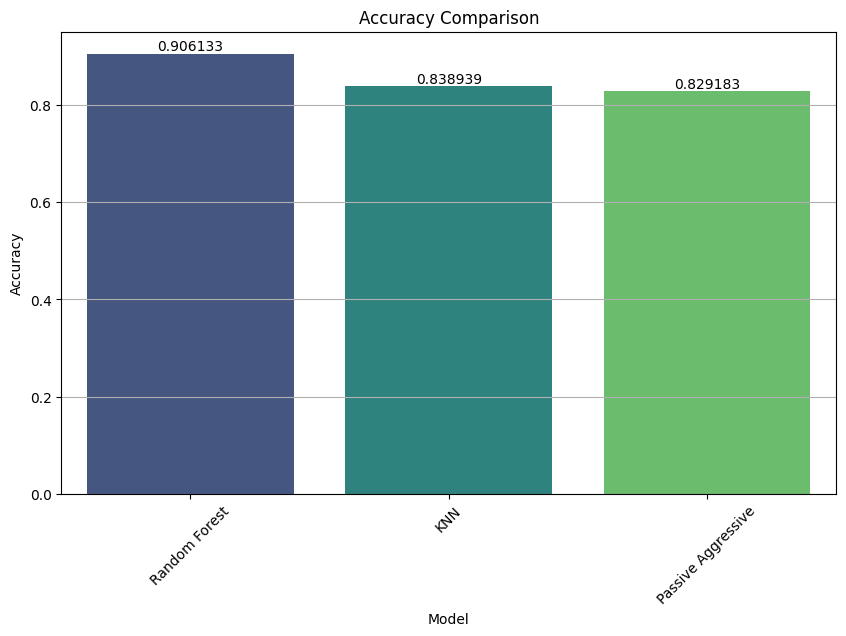

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Model', y='Accuracy', hue='Model', data=results_df, palette='viridis', dodge=False, legend=False)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values per bar
for container in ax2.containers:
    ax2.bar_label(container)
plt.show()

In [ ]:
cmx_colors = ['Blues', 'Greens', 'Reds', 'Oranges']

def plot_confusion_matrices(models, model_names, X_test, y_test, colors):
    plt.figure(figsize=(24, 18)) 

    for i, (model, model_name, color) in enumerate(zip(models, model_names, colors), start=1):
        # Get predictions 
        y_pred = model.predict(X_test)

        # Calculate confusion matrix
        confusion = confusion_matrix(y_test, y_pred)
        cmx = ConfusionMatrixDisplay(confusion_matrix=confusion)

        # Subplot for current model
        plt.subplot(2, 2, i)

        # Plot confusion matrix with specified color scheme
        cmx.plot(cmap=color, ax=plt.gca())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(model_name)

    plt.tight_layout()
    plt.show()


plot_confusion_matrices(models.values(), models.keys(), X_test, y_test, cmx_colors)

IndexError: list index out of range

<Figure size 2400x1800 with 0 Axes>